<div id="section1"   dir='rtl'>
    <h2>
 در این گام به بررسی فایل log می پردازیم</div>
</h2>
        <hr>

Installing Spark
Install Dependencies:
```
1.   Java 8
2.   Apache Spark with hadoop and
3.Findspark (used to locate the spark in the system)

In [1]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q http://archive.apache.org/dist/spark/spark-3.1.1/spark-3.1.1-bin-hadoop3.2.tgz
!tar xf spark-3.1.1-bin-hadoop3.2.tgz
!pip install -q findspark

Set Environment Variables:



In [2]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.1.1-bin-hadoop3.2"

In [3]:
!ls

sample_data  spark-3.1.1-bin-hadoop3.2	spark-3.1.1-bin-hadoop3.2.tgz


In [4]:
import findspark
findspark.init()
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()
spark.conf.set("spark.sql.repl.eagerEval.enabled", True) 
spark

<div id="section1"   dir='**rtl**'>
    <h2>
 install to googledrive</div>
</h2>
        <hr>



In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


<div id="section1"   dir='rtl'>
    <h2>
 کتابخانه های مورد نیاز را ایمپورت می کنیم</div>
</h2>
        <hr>


In [6]:
import matplotlib.pyplot as plt
import seaborn as sns


<div id="section1"   dir='rtl'>
    <h2>
خواندن فایل در اسپارک
      :::  با استفاده از تابع read.text در اسپارک  فایل log را از گوگل درایو می خوانیم
    </h2>
        <hr>
</div>

In [7]:
logfile=spark.read.text("/content/drive/MyDrive/spark/Datasets/2/Log")

<div id="section1"   dir='rtl'>
    <h2>
با استفاده از تابع take  یک دید کوچک از  فایل log بدست می اوریم</div>
</h2>
        <hr>

In [9]:
logfile.take(10)

[Row(value='199.72.81.55 - - [01/Jul/1995:00:00:01 -0400] "GET /history/apollo/ HTTP/1.0" 200 6245'),
 Row(value='unicomp6.unicomp.net - - [01/Jul/1995:00:00:06 -0400] "GET /shuttle/countdown/ HTTP/1.0" 200 3985'),
 Row(value='199.120.110.21 - - [01/Jul/1995:00:00:09 -0400] "GET /shuttle/missions/sts-73/mission-sts-73.html HTTP/1.0" 200 4085'),
 Row(value='burger.letters.com - - [01/Jul/1995:00:00:11 -0400] "GET /shuttle/countdown/liftoff.html HTTP/1.0" 304 0'),
 Row(value='199.120.110.21 - - [01/Jul/1995:00:00:11 -0400] "GET /shuttle/missions/sts-73/sts-73-patch-small.gif HTTP/1.0" 200 4179'),
 Row(value='burger.letters.com - - [01/Jul/1995:00:00:12 -0400] "GET /images/NASA-logosmall.gif HTTP/1.0" 304 0'),
 Row(value='burger.letters.com - - [01/Jul/1995:00:00:12 -0400] "GET /shuttle/countdown/video/livevideo.gif HTTP/1.0" 200 0'),
 Row(value='205.212.115.106 - - [01/Jul/1995:00:00:12 -0400] "GET /shuttle/countdown/countdown.html HTTP/1.0" 200 3985'),
 Row(value='d104.aa.net - - [01/Ju

<div id="section1"   dir='rtl'>
    <h2>
 قبل اینکه فایل log را به دیتافریم تبدیل کنیم یک دیدی از تعداد کل فایل log می خواهیم داشته باشیم که چه تعداد است همانطور که میبینیم کل فایل log در یک ستون قرار دارد پس باید ستون ها را از هم جدا کنیم که در ادامه اینکارا خواهیم کرد.</div>
</h2>
        <hr>


In [10]:
print((logfile.count(), len(logfile.columns)))

(1891715, 1)


we must write some regular expressions to extract the columns from the logs:
<div id="section1"   dir='rtl'>
    <h2>
 برای جدا کردن و استخراج ستون ها از این فایل باید عبارات منظم برای هر ستون بنویسیم</div>
</h2>
        <hr>



In [11]:
host_pattern = r'(^\S+\.[\S+\.]+\S+)\s'
timespan_pattern = r'\[(\d{2}/\w{3}/\d{4}:\d{2}:\d{2}:\d{2} -\d{4})]'
method_uri_protocol_pattern = r'\"(\S+)\s(\S+)\s*(\S*)\"'
status_pattern = r'\s(\d{3})\s'
content_size_pattern = r'\s(\d+)$'


leverage all the regular expression patterns(convert to dataframe)

<div id="section1"   dir='rtl'>
    <h2>
از تابع select و regexp_extract در اسپارک برای ساختن دیتافریم با استفاده از الگوهای منظمی که در گام قبل ست کردیم، استفاده می کنیم .
  و نام هر ستون را با تابع alias به اسم های انتخابی خود ست می کنیم همانطور که در جدول می بینیم کل فایل log به یک دیتافریم 7 ستونه تبدیل شد.   </div>
</h2>
        <hr>
<div id="section1"   dir='rtl'>
    <h2>
    regexp_extract function::::

یک گروه خاص را که مطابق با  regex است ، از ستون رشته مشخص شده استخراج می کند. اگر regex مطابقت نداشته باشد یا گروه مشخص شده مطابقت نداشته باشد ، یک رشته خالی بازگردانده می شود.  </div>
</h2>
        <hr>

In [12]:
from pyspark.sql.functions import regexp_extract

logs_data = logfile.select(regexp_extract('value', host_pattern, 1).alias('host'),
                         regexp_extract('value', timespan_pattern, 1).alias('timestamp'),
                         regexp_extract('value', method_uri_protocol_pattern, 1).alias('method'),
                         regexp_extract('value', method_uri_protocol_pattern, 2).alias('endpoint'),
                         regexp_extract('value', method_uri_protocol_pattern, 3).alias('protocol'),
                         regexp_extract('value', status_pattern, 1).cast('integer').alias('status'),
                         regexp_extract('value', content_size_pattern, 1).cast('integer').alias('content_size'))
logs_data.show(20, truncate=True)
print((logs_data.count(), len(logs_data.columns)))

+--------------------+--------------------+------+--------------------+--------+------+------------+
|                host|           timestamp|method|            endpoint|protocol|status|content_size|
+--------------------+--------------------+------+--------------------+--------+------+------------+
|        199.72.81.55|01/Jul/1995:00:00...|   GET|    /history/apollo/|HTTP/1.0|   200|        6245|
|unicomp6.unicomp.net|01/Jul/1995:00:00...|   GET| /shuttle/countdown/|HTTP/1.0|   200|        3985|
|      199.120.110.21|01/Jul/1995:00:00...|   GET|/shuttle/missions...|HTTP/1.0|   200|        4085|
|  burger.letters.com|01/Jul/1995:00:00...|   GET|/shuttle/countdow...|HTTP/1.0|   304|           0|
|      199.120.110.21|01/Jul/1995:00:00...|   GET|/shuttle/missions...|HTTP/1.0|   200|        4179|
|  burger.letters.com|01/Jul/1995:00:00...|   GET|/images/NASA-logo...|HTTP/1.0|   304|           0|
|  burger.letters.com|01/Jul/1995:00:00...|   GET|/shuttle/countdow...|HTTP/1.0|   200|    

#step 1

<div id="section1"   dir='rtl'>
    <h2>
    در اولین گام از این بخش می خواهیم تعداد هاست های یکتا را پیدا کنیم که در این فایل هاست ها دونوع هستند یک سری  با ip مشخص شدند و یک سری دامنه هستند
  </div>
</h2>
        <hr>

<div id="section1"   dir='rtl'>
    <h2>
برای اینکار از تابع select در اسپارک استفاده می کنیم تا ستون مدنظر را انتخاب کنیم سپس با استفاده از تابع distinct که مقادیر تکرار شده را حذف می کند، استفاده می کنیم ( صرفا هاست های uniqe را به ما می دهد)  و در نهایت با دستور count تعداد را می شماریم. همه ی این کارها را در یک خط می توان انجام داد
  </div>
</h2>
        <hr>

In [13]:
unique_host = (logs_data.select('host').distinct().count())
unique_host

81961

#step2

<div id="section1"   dir='rtl'>
    <h2>
این گام 2 بخش دارد در بخش اول از ما خواسته شده که تعداد درخواست های روزانه برای  هر هاست منحصر به فرد را به دست اوریم
  </div>
</h2>
        <hr>

<div id="section1"   dir='rtl'>
    <h2>
با میس ولیوها کاری نداریم صرفا برای اینکه ببینیم در این دیتاست چه تعداد میس ولیو وجود دارد می توانیم ار تابع پایه filter در اسپارک و isNull برای هر ستون استفاده کنیم و در نهایت با تابع count تعداد کل را بشماریم 
  </div>
</h2>
        <hr>

In [14]:
nullcolumns= logs_data.filter(logs_data['host'].isNull()|
                             logs_data['timestamp'].isNull() |
                             logs_data['method'].isNull() |
                             logs_data['endpoint'].isNull() |
                             logs_data['status'].isNull() |
                             logs_data['content_size'].isNull()|
                             logs_data['protocol'].isNull())
nullcolumns.count()

19727

**we have over 19K missing values in our data!** 

In [15]:
from pyspark.sql.functions import split

<div id="section1"   dir='rtl'>
    <h2>
اولین کاری که برای بخش اول باید انجام دهیم چون به صورت روزانه از ماخواسته شده پس باید ستون تاریخ را جدا کنیم برای اینکار date  را از زمان از  timestamp جدا می کنیم که کافی است به الگوی timestamp نگاه کنیم و ببینیم تاریخ به وسیله : از زمان جدا شده است.(می توانستیم یکسره روز را از timestamp جدا کنیم و دیگر لزومی به ساختن ستون جدید به نام Date نباشد اما من شک کردم که نکند ماه های دیگر یا سال های دیگرم در این تاریخ دخیل باشند چون در ان صورت ریزالت متفاوت می شد برای همین ابتدا ستون تاریخ را جدا می کنم و بعد در ادامه متوجه می شوم که نه صرفا اطلاعات 28 روز از ماه یکسان در تاریخ 1995 است)
  </div>
</h2>
        <hr>

In [16]:
split_cols = split(logs_data['timestamp'], '\:')


<div id="section1"   dir='rtl'>
    <h2>
سپس با استفاده از تابع getitem  خانه ی اول ستون timestamp که تاریخ است را دریافت و در ستون جدید به اسم Date می ریزیم
  </div>
</h2>
        <hr>

In [17]:
logs_data  = logs_data.withColumn('Date', split_cols.getItem(0))
logs_data

host,timestamp,method,endpoint,protocol,status,content_size,Date
199.72.81.55,01/Jul/1995:00:00...,GET,/history/apollo/,HTTP/1.0,200,6245,01/Jul/1995
unicomp6.unicomp.net,01/Jul/1995:00:00...,GET,/shuttle/countdown/,HTTP/1.0,200,3985,01/Jul/1995
199.120.110.21,01/Jul/1995:00:00...,GET,/shuttle/missions...,HTTP/1.0,200,4085,01/Jul/1995
burger.letters.com,01/Jul/1995:00:00...,GET,/shuttle/countdow...,HTTP/1.0,304,0,01/Jul/1995
199.120.110.21,01/Jul/1995:00:00...,GET,/shuttle/missions...,HTTP/1.0,200,4179,01/Jul/1995
burger.letters.com,01/Jul/1995:00:00...,GET,/images/NASA-logo...,HTTP/1.0,304,0,01/Jul/1995
burger.letters.com,01/Jul/1995:00:00...,GET,/shuttle/countdow...,HTTP/1.0,200,0,01/Jul/1995
205.212.115.106,01/Jul/1995:00:00...,GET,/shuttle/countdow...,HTTP/1.0,200,3985,01/Jul/1995
d104.aa.net,01/Jul/1995:00:00...,GET,/shuttle/countdown/,HTTP/1.0,200,3985,01/Jul/1995
129.94.144.152,01/Jul/1995:00:00...,GET,/,HTTP/1.0,200,7074,01/Jul/1995


<div id="section1"   dir='rtl'>
    <h2>
می توانیم با همین ستون به صورت کلی کار کنیم چون من با روش زیر دیدم کلا 28 روز در این دیتاست داریم و ماه و سال یکی است ولی من ترجیح دادم یکسره با ستون روز ستون timestamp کار کنم که فرقی نمی کند ریزالت یکی است. .
  </div>
</h2>
        <hr>

In [18]:
from pyspark.sql.functions import col


In [19]:
unique_Date = (logs_data.select('Date').distinct()).orderBy(col("Date").desc())
unique_Date.show(30)

+-----------+
|       Date|
+-----------+
|28/Jul/1995|
|27/Jul/1995|
|26/Jul/1995|
|25/Jul/1995|
|24/Jul/1995|
|23/Jul/1995|
|22/Jul/1995|
|21/Jul/1995|
|20/Jul/1995|
|19/Jul/1995|
|18/Jul/1995|
|17/Jul/1995|
|16/Jul/1995|
|15/Jul/1995|
|14/Jul/1995|
|13/Jul/1995|
|12/Jul/1995|
|11/Jul/1995|
|10/Jul/1995|
|09/Jul/1995|
|08/Jul/1995|
|07/Jul/1995|
|06/Jul/1995|
|05/Jul/1995|
|04/Jul/1995|
|03/Jul/1995|
|02/Jul/1995|
|01/Jul/1995|
|           |
+-----------+



<div id="section1"   dir='rtl'>
   
   <div id="section1"   dir='rtl'>
    <h2>

  </div>
</h2>
        <hr> <h2>
 از تابع split استفاده می کنیم      .اگر به فرمت ستون timestamp نگاه کنیم، متوجه می شویم روز و ماه و سال  به صورت / از هم جدا شدند،  پس کافی است انها را به صورت / از هم جدا کنیم سپس می بینیم که همون خانه ی صفر روز است و روز را دریافت ودر یک ستون جدید به نام day می ریزیم
 
  </div>
</h2>
        <hr>

In [20]:
split_cols3 = split(logs_data['timestamp'], '/')
logs_data = logs_data.withColumn('day', split_cols3.getItem(0))

#show new dataset with new column (day)

In [21]:
logs_data.show(20, truncate=True)

+--------------------+--------------------+------+--------------------+--------+------+------------+-----------+---+
|                host|           timestamp|method|            endpoint|protocol|status|content_size|       Date|day|
+--------------------+--------------------+------+--------------------+--------+------+------------+-----------+---+
|        199.72.81.55|01/Jul/1995:00:00...|   GET|    /history/apollo/|HTTP/1.0|   200|        6245|01/Jul/1995| 01|
|unicomp6.unicomp.net|01/Jul/1995:00:00...|   GET| /shuttle/countdown/|HTTP/1.0|   200|        3985|01/Jul/1995| 01|
|      199.120.110.21|01/Jul/1995:00:00...|   GET|/shuttle/missions...|HTTP/1.0|   200|        4085|01/Jul/1995| 01|
|  burger.letters.com|01/Jul/1995:00:00...|   GET|/shuttle/countdow...|HTTP/1.0|   304|           0|01/Jul/1995| 01|
|      199.120.110.21|01/Jul/1995:00:00...|   GET|/shuttle/missions...|HTTP/1.0|   200|        4179|01/Jul/1995| 01|
|  burger.letters.com|01/Jul/1995:00:00...|   GET|/images/NASA-l

##first part of this step

<div id="section1"   dir='rtl'>
    <h2>
در ادامه  2 ستون روز و هاست را با دستور select ار دیتاست جدا می کنیم چون صرفا با این دو ستون کار داریم
  </div>
</h2>
        <hr>

In [22]:
host_day_df = logs_data.select(logs_data.host,logs_data.day)  
host_day_df.show(10, truncate=False)

+--------------------+---+
|host                |day|
+--------------------+---+
|199.72.81.55        |01 |
|unicomp6.unicomp.net|01 |
|199.120.110.21      |01 |
|burger.letters.com  |01 |
|199.120.110.21      |01 |
|burger.letters.com  |01 |
|burger.letters.com  |01 |
|205.212.115.106     |01 |
|d104.aa.net         |01 |
|129.94.144.152      |01 |
+--------------------+---+
only showing top 10 rows



<div id="section1"   dir='rtl'>
    <h2>
برای اینکه ببینیم هر هاست منحصر به فرد در هر روز چه تعداد از سایت مثلا بازدید کرده است از دستور groupby استفاده می کنیم و بر اساس روز و هاست گروه بندی می کنیم و تعداد بازدید برای هر هاست منحصر به فرد را برای هر روز به دست می اوریم.
)من  این سوال را از اقای بنایی پرسیدم و ایشون فرمودند متوسط در بخش اول اضافی است و انرا حذف کنیم بنابراین من هم تعداد را در بخش اول صرفا بدست اوردم
  </div>
</h2>
        <hr>

In [24]:
daily_hosts_df = (host_day_df.groupBy('host','day').count())                  
daily_hosts_df.show(100)

+--------------------+---+-----+
|                host|day|count|
+--------------------+---+-----+
|ip36.herndon2.va....| 01|    6|
| modem72.ucdavis.edu| 01|    5|
|         202.6.90.68| 01|   24|
|dialup97-045.swip...| 01|    9|
| perseus.peganet.com| 01|    1|
|kenwong.magna.com.au| 01|    4|
| p235.infolink.co.za| 01|    7|
|bridgewater-ts-11...| 01|    4|
|halifax-ts4-05.ns...| 01|   16|
|  port19.wasatch.com| 01|    4|
| fouad.ncsa.uiuc.edu| 01|    3|
|       137.91.20.212| 01|    4|
|port11.gateway2.i...| 01|    9|
|dd14-041.compuser...| 01|    1|
| arnetpc-204.arn.net| 01|    4|
|ziggurat.nightmar...| 01|    9|
|pm-nb1-49.coastal...| 01|   14|
|       204.254.185.9| 01|    9|
| tty19-01.swipnet.se| 01|    7|
|tip-mp5-ncs-4.sta...| 01|    4|
|     141.244.135.146| 01|   29|
| trillian.execpc.com| 01|    9|
|ix-wp1-14.ix.netc...| 01|   10|
|        rsd.xnet.com| 01|   15|
|slip168-91.sy.au....| 01|    4|
|        134.190.9.69| 01|   11|
| dp030.ppp.iglou.com| 01|    7|
|ppp-13-ne

##second part of this step

<div id="section1"   dir='rtl'>
    <h2>
در بخش دوم گفته شده که میانگین هر هاست را در به طور کلی در برای این سایت به دست اوریم که می توانیم صرفا یک میانگین کلی از تعدادی که برای هر هاست منحصر به فرد بدست اوردیم بگیریم تا ببینیم مثلا یک هاست مدنظر چه تعداد به طور کلی بازدید از سایت در طول این 28 روز داشته است(من به صورت سورت شده نشان دادم).
  </div>
</h2>
        <hr>

In [25]:
total_hosts_df = (daily_hosts_df.groupBy('host').avg()).orderBy(col("avg(count)").desc())                   
total_hosts_df

host,avg(count)
rush.internic.net,1119.0
siltb10.orl.mmc.com,841.4444444444445
piweba3y.prodigy.com,627.5714285714286
marina.cea.berkel...,599.6666666666666
alyssa.prodigy.com,523.4666666666667
nidhogg.srl.calte...,506.5
piweba4y.prodigy.com,482.9583333333333
bill.ksc.nasa.gov,445.14285714285717
spidey.cor.epa.gov,401.0
hoohoo.ncsa.uiuc.edu,367.0


#step 3

<div id="section1"   dir='rtl'>
    <h2>
در این گام از ما خواسته شده که تعداد فایل های گیف را بدست اوریم همانطور که می دانیم فایل های گیف در ستونendpoint هستندکه باز هم اگر به فرمت فایل های ذخیره شده در این ستون نگاه کنیم می بینیم قسمت انتهایی این ستون با نقطه جدا شده است و پس از تابع split استفاده می کنیم تا نام هر سطر این ستون را بشکانیم
  </div>
</h2>
        <hr>

In [26]:
 from pyspark.sql.functions import size

In [27]:
split_dot = split(logs_data['endpoint'], '\.')


<div id="section1"   dir='rtl'>
    <h2>
سپس یک ستون جدید به اسم فرمت فایل می سازیم که در این ستون مقادیری قرار می گیرند که در ستون endpoint با نقطه جدا شده بودند واز تابع getitem  استفاده می کنیم و با استفاده از تابع سایز در اسپارک هر کدام به یک خانه از ارایه تیدیل می شوند و خانه اخر را می گیریم که همون فرمت این فایل ها است.
  </div>
</h2>
        <hr>

In [28]:
logs_data = logs_data.withColumn('formatfile', split_dot.getItem(size(split_dot) - 1))

<div id="section1"   dir='rtl'>
    <h2>
در این ستون فرمت فایل ، فایل هایی که فرمت گیف دارند به دو صورت هستند هم با حرف کوچک و هم بزرگ، پس هر دو نوع را با استفاده از تابع filter پیدا می کنیم 
و با استفاده از count مقادیر این دو را جمع می کینم.
  </div>
</h2>
        <hr>

In [29]:
gifs_l = logs_data.filter((logs_data['formatfile'])=='gif')
gifs_b = logs_data.filter((logs_data['formatfile'])=='GIF')

In [31]:
print(f"count of gif_GIF file :{gifs_l.count()+gifs_b.count()}")


count of gif_GIF file :1043884


#step 4

<div id="section1"   dir='rtl'>
    <h2>
این گام دو بخش دارد در بخش اول از ما خواسته شده که دامنه های پرتقاضا بیش از 3 بار که صرفا دامنه هستند به صورت مرتب شده نشان دهیم برای اینکار با دستور select ستون هاست را می گیریم
  </div>
</h2>
        <hr>

##first part of this step

In [32]:
most_host_df = logs_data.select(logs_data.host)
most_host_df.show(10, truncate=False)

+--------------------+
|host                |
+--------------------+
|199.72.81.55        |
|unicomp6.unicomp.net|
|199.120.110.21      |
|burger.letters.com  |
|199.120.110.21      |
|burger.letters.com  |
|burger.letters.com  |
|205.212.115.106     |
|d104.aa.net         |
|129.94.144.152      |
+--------------------+
only showing top 10 rows



 <div id="section1"   dir='rtl'>
    <h2>
ابتدا با دستور گروپ بای و count تعداد هر هاست منحصر به فرد را بدست می اوریم 
  </div>
</h2>
        <hr>
                 

In [33]:
most_hosts_df = (most_host_df.groupBy('host').count())                    
most_hosts_df

host,count
ppp3_136.bekkoame...,39
ppp31.texoma.com,21
ix-wc7-20.ix.netc...,40
nb1-du5.polarnet....,25
ttyb5.shasta.com,19
dialup00004.cinet...,10
dd14-025.compuser...,18
nigrlpr.actrix.ge...,3
uckm001.pn.itnet.it,34
queulen.puc.cl,87


<div id="section1"   dir='rtl'>
    <h2>
از انجایی که در صورت سوال ذکر شده است که در هاست صرفا دامنه ها گرفته شود یک راه این است که یک ستون جدید اضافه کنم و کسانی که دامنه هستند را در ان ستون نال کنیم و از این ستون نال شده برای دامنه استفاده کنیم در ادامه بیشتر توضیح می دهم
  </div>
</h2>
        <hr>

<div id="section1"   dir='rtl'>
    <h2>
برای ایجاد یک ستون جدید به این طریق عمل می کنیم که به فرمت دامنه ها و ip ها در ستون هاست نگاه می کنیم، می بینیم که با نقطه از هم جدا شدند و ما می توانی با قسمت اخر این فرمت ناهم کار کنیم چون فرمت های ip قسمت اخرشان عدد هستند اما فرمت دامنه قسمت اخرشان حرف مثلا comو... هستند 
ابتدا از دستور split استفاده می کنیم
  </div>
</h2>
        <hr>

In [34]:
splitname= split(most_hosts_df['host'], '\.')


<div id="section1"   dir='rtl'>
    <h2>
<div id="section1"   dir='rtl'>
    <h2>
سپس یک ستون جدید به اسم  name می سازیم که در این ستون مقادیری قرار می گیرند که در ستون host با نقطه جدا شده بودند واز تابع getitem  استفاده می کنیم و با استفاده از تابع سایز در اسپارک هر کدام به یک خانه از ارایه تیدیل می شوند و خانه اخر را می گیریم .
  </div>
</h2>
        <hr>
  </div>
</h2>
        <hr>

In [35]:
most__hosts_df = most_hosts_df.withColumn('name', splitname.getItem(size(splitname) - 1))
most__hosts_df

host,count,name
ppp3_136.bekkoame...,39,jp
ppp31.texoma.com,21,com
ix-wc7-20.ix.netc...,40,com
nb1-du5.polarnet....,25,us
ttyb5.shasta.com,19,com
dialup00004.cinet...,10,net
dd14-025.compuser...,18,com
nigrlpr.actrix.ge...,3,nz
uckm001.pn.itnet.it,34,it
queulen.puc.cl,87,cl


<div id="section1"   dir='rtl'>
    <h2>
در اینجا از sql استفاده می کنیم و خانه های ستون name را int می کنیم که این کار باعث می شود  دامنه ها که خانه ی اخر انها در این ستون قرار دارند و حرف هستند به null تبدیل شوند
  </div>
</h2>
        <hr>

In [36]:
most__hosts_df.createOrReplaceTempView("CastExample")
df = spark.sql("SELECT host,count,int(name) from CastExample")
df

host,count,name
ppp3_136.bekkoame...,39,null
ppp31.texoma.com,21,null
ix-wc7-20.ix.netc...,40,null
nb1-du5.polarnet....,25,null
ttyb5.shasta.com,19,null
dialup00004.cinet...,10,null
dd14-025.compuser...,18,null
nigrlpr.actrix.ge...,3,null
uckm001.pn.itnet.it,34,null
queulen.puc.cl,87,null


<div id="section1"   dir='rtl'>
    <h2>
سپس با استفاده از دستور filter ان سطرهایی که در ستون name نال هستند را دریافت می کنیم که این خانه ها، همان دامنه های ما هستند
  </div>
</h2>
        <hr>

In [37]:
df=df.filter(df.name.isNull())

In [39]:
from pyspark.sql.functions import col


<div id="section1"   dir='rtl'>
    <h2>
سپس کافی است با استفاده از filter دامنه هایی که تعداد بازدیدشان بیشتر از 3 هست را دریافت و بر اساس تعداد انها را سورت کنیم و نشان دهیم
  </div>
</h2>
        <hr>

In [40]:
maxhost = (df.filter((df['count']>3)).orderBy(col("count").desc()))
maxhost.select('host','count')

host,count
piweba3y.prodigy.com,17572
piweba4y.prodigy.com,11591
piweba1y.prodigy.com,9868
alyssa.prodigy.com,7852
siltb10.orl.mmc.com,7573
piweba2y.prodigy.com,5922
edams.ksc.nasa.gov,5434
news.ti.com,4863
,4797
disarray.demon.co.uk,4353


second part of this step

<div id="section1"   dir='rtl'>
    <h2>
در بخش دوم از این سوال از ما خواسته شده پرتقاضاترین دامنه های هر روز را بدست اوریم تا بخشی از کار مانند مرحله ی قبل است و در ابتدا ستون روز و هاست را دریافت می کنیم
  </div>
</h2>
        <hr>

In [41]:
most_host_df_daily = logs_data.select(logs_data.host,logs_data.day)
most_host_df_daily.show(10, truncate=False)

+--------------------+---+
|host                |day|
+--------------------+---+
|199.72.81.55        |01 |
|unicomp6.unicomp.net|01 |
|199.120.110.21      |01 |
|burger.letters.com  |01 |
|199.120.110.21      |01 |
|burger.letters.com  |01 |
|burger.letters.com  |01 |
|205.212.115.106     |01 |
|d104.aa.net         |01 |
|129.94.144.152      |01 |
+--------------------+---+
only showing top 10 rows



<div id="section1"   dir='rtl'>
    <h2>
بر اسااس روز و هاست گروه بندی می کنیم تا تعداد هاست های منحصر به فرد هر روز را پیدا کنیم
  </div>
</h2>
        <hr>

In [42]:
most_daily_hosts_df = (most_host_df_daily.groupBy('host','day').count())                  
most_daily_hosts_df

host,day,count
ip36.herndon2.va....,01,6
modem72.ucdavis.edu,01,5
202.6.90.68,01,24
dialup97-045.swip...,01,9
perseus.peganet.com,01,1
kenwong.magna.com.au,01,4
p235.infolink.co.za,01,7
bridgewater-ts-11...,01,4
halifax-ts4-05.ns...,01,16
port19.wasatch.com,01,4


<div id="section1"   dir='rtl'>
    <h2>
برای جدا کردن دامنه از ip مانند روش قبل عمل می کنیم که در مرحله ی قبل توضیح داده شد
</h2>
        <hr>

In [43]:
splitname2= split(most_daily_hosts_df['host'], '\.')
most__hosts_df2 = most_daily_hosts_df.withColumn('name', splitname2.getItem(size(splitname2) - 1))
most__hosts_df2

host,day,count,name
ip36.herndon2.va....,01,6,com
modem72.ucdavis.edu,01,5,edu
202.6.90.68,01,24,68
dialup97-045.swip...,01,9,se
perseus.peganet.com,01,1,com
kenwong.magna.com.au,01,4,au
p235.infolink.co.za,01,7,za
bridgewater-ts-11...,01,4,ca
halifax-ts4-05.ns...,01,16,ca
port19.wasatch.com,01,4,com


In [44]:
most__hosts_df2.createOrReplaceTempView("CastExample2")
df2 = spark.sql("SELECT host,day,count,int(name) from CastExample2")
df2

host,day,count,name
ip36.herndon2.va....,01,6,null
modem72.ucdavis.edu,01,5,null
202.6.90.68,01,24,68
dialup97-045.swip...,01,9,null
perseus.peganet.com,01,1,null
kenwong.magna.com.au,01,4,null
p235.infolink.co.za,01,7,null
bridgewater-ts-11...,01,4,null
halifax-ts4-05.ns...,01,16,null
port19.wasatch.com,01,4,null


In [45]:
df2=df2.filter(df2.name.isNull())
df2

host,day,count,name
ip36.herndon2.va....,01,6,null
modem72.ucdavis.edu,01,5,null
dialup97-045.swip...,01,9,null
perseus.peganet.com,01,1,null
kenwong.magna.com.au,01,4,null
p235.infolink.co.za,01,7,null
bridgewater-ts-11...,01,4,null
halifax-ts4-05.ns...,01,16,null
port19.wasatch.com,01,4,null
fouad.ncsa.uiuc.edu,01,3,null


<div id="section1"   dir='rtl'>
    <h2>
حال با دستور max ماکسیمم تعداد هاستی که در هر روز وجود داشت را پیدا می کنیم
  </div>
</h2>
        <hr>

In [46]:
df3 = (df2.groupBy('day').max('count'))                
df3

day,max(count)
07,879
15,974
11,1394
01,623
22,700
28,353
16,1280
18,700
27,283
17,850


<div id="section1"   dir='rtl'>
    <h2>
اما چون نام این هاست ها را می خواهیم ابتدا چون تعداد در جدول اول با جدول بدست امده یکی است ، نام ها را یکسان ست کنیم سپس از join استفاده کنیم تا نام هاست ها را دریافت کنیم.در ادامه بیشتر توضیح می دهم  </div>
</h2>
        <hr>

In [48]:
from pyspark.sql.functions import col

mapping = dict(zip(['day', 'max(count)']

                   , ['day', 'count']))
df4=df3.select([col(c).alias(mapping.get(c, c)) for c in df3.columns])
df4

day,count
07,879
15,974
11,1394
01,623
22,700
28,353
16,1280
18,700
27,283
17,850


<div id="section1"   dir='rtl'>
    <h2>
برای join من از sql استفاده کردم به این ترتیب که 2 جدول را گرفتم سپس روز و تعداد را در این جدول مقایسه کردم و هر جا که روز و تعداد (یک جدول همان جدول ماکس ما است)با جدول df4 که جدول ماکس ما هست برابر بود نام دامنه و تعداد و روز را دریافت می کنیم و سپس برای  پرتقاضاترین را برای هر روز به صورت سورت شده از اخرین روز تا روز اولی که در این logfile هست نشان می دهیم مثلا در روز 28 ام هاست مدنظر بیشترین تعداد بازید سایت را با 353 بار داشته است   
  </div>
</h2>
        <hr>

In [49]:
df2.createOrReplaceTempView("df2")
df4.createOrReplaceTempView("df4")

sqlDF_maxhost = spark.sql("select host,df4.day,df4.count from df2,df4 where df2.count = df4.count and df2.day=df4.day;")
sqlDF_maxhost.orderBy(col("day").desc()).show(30, truncate=False)

+---------------------------+---+-----+
|host                       |day|count|
+---------------------------+---+-----+
|pcmas.it.bton.ac.uk        |28 |353  |
|edams.ksc.nasa.gov         |27 |283  |
|piweba3y.prodigy.com       |26 |312  |
|jbiagioni.npt.nuwc.navy.mil|25 |763  |
|                           |24 |399  |
|currypc.fpl.msstate.edu    |23 |709  |
|currypc.fpl.msstate.edu    |22 |700  |
|siltb10.orl.mmc.com        |21 |1354 |
|siltb10.orl.mmc.com        |20 |884  |
|siltb10.orl.mmc.com        |19 |847  |
|                           |18 |700  |
|siltb10.orl.mmc.com        |17 |850  |
|piweba3y.prodigy.com       |16 |1280 |
|piweba4y.prodigy.com       |15 |974  |
|piweba4y.prodigy.com       |14 |1029 |
|piweba3y.prodigy.com       |13 |1202 |
|indy.gradient.com          |12 |1356 |
|bill.ksc.nasa.gov          |11 |1394 |
|e659229.boeing.com         |10 |358  |
|alyssa.prodigy.com         |09 |545  |
|piweba3y.prodigy.com       |08 |781  |
|piweba3y.prodigy.com       |07 |879  |


#step 5


<div id="section1"   dir='rtl'>
    <h2>
در این گام از ما خواسته شده است که خطاهای غیر 200 را پیدا کنیم و در نمودار نشان دهیم که برای اینکار ایتدا از ستون status که خطاها در این ستون قرار دارند، با استفاده از تابع filter خطاهای غیر 200 را دریافت می کنیم سپس این خطاها را گروپ بای می کنیم و تعداد هر کدام را می گیریم و نمایش می دهیم
  </div>
</h2>
        <hr>

In [50]:
not200_df = (logs_data.filter(logs_data['status'] != 200))
error_status_freq_df = (not200_df.groupBy('status').count().limit(20) )                  
error_status_freq_df.show(truncate=False)  

+------+------+
|status|count |
+------+------+
|501   |14    |
|500   |62    |
|400   |5     |
|403   |54    |
|404   |10843 |
|304   |132627|
|302   |46573 |
+------+------+



<div id="section1"   dir='rtl'>
    <h2>
برای اینکه در نمودار نشان دهیم به پانداز تبدیل می کنیم و انها را بر اساس تعداد سورت می کنیم 
  </div>
</h2>
        <hr>

In [51]:
error_status_freq_df = (error_status_freq_df.toPandas().sort_values(by=['count'],ascending=False))
error_status_freq_df

,status,count
5,304,132627
6,302,46573
4,404,10843
1,500,62
3,403,54
0,501,14
2,400,5


<div id="section1"   dir='rtl'>
    <h2>
سپس با استفاده از seaborn بارپلات را برای این خطاها رسم می کنیم که همانطور که در پیش تر هم بدست اورده بودیم خطای 304 بیشترین بار اتفاق افتاده است.
  </div>
</h2>
        <hr>

In [52]:
import seaborn as sns

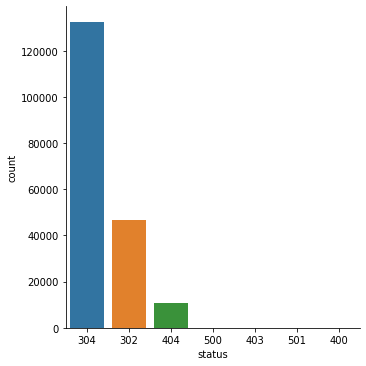

In [53]:
sns.catplot(x='status', y='count', data=error_status_freq_df,kind='bar', order=error_status_freq_df['status']);
